<a href="https://colab.research.google.com/github/tkd8973/DL_Project/blob/main/tkd8973/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의존성

In [ ]:
# 이미지 처리
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 파이토치
import torch
import torch.optim as optim
from torchvision import transforms, models

# 딥러닝 모델

In [ ]:
# VGG19의 "features" 부분을 가져옵니다
# ("classifier" 부분은 필요하지 않습니다).
# 일반적으로 전이학습(transfer learning)에서는
# "features" 부분만을 가져와서 사용하고, "classifier"는 버리거나 새롭게 정의합니다.
# 이는 대부분의 경우 "features" 부분이 이미지의 고수준 특성을 추출하는 데 더 중요하며,
# 이를 기반으로 새로운 모델을 학습하는 것이 더 효과적이기 때문입니다.
vgg = models.vgg19(pretrained=True).features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 116MB/s] 


In [ ]:
# 대상 이미지만 최적화하므로 모든 VGG 파라미터를 고정합니다.
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
# 사용 가능한 경우 모델을 GPU로 이동합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 이미지 불러오기

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    '''
    이미지를 불러와서 변환하고,
    이미지가 x-y 비율에서
    400픽셀 미만인지 확인합니다.
    '''
    
    # 이미지가 크면 처리 속도가 느려집니다.
    image = Image.open(img_path).convert('RGB')
    
    if shape is not None:
        size = shape
    else:
        size = max_size if max(image.size) > max_size else max(image.size)    

    # 이미지 전처리 및 텐서화
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                                (0.229, 0.224, 0.225))])

    # 투명한 알파 채널(즉, :3)을 삭제하고 배치 차원을 추가합니다.    
    return in_transform(image)[:3,:,:].unsqueeze(0)

In [ ]:
# 파일 다운로드 및 정리
!wget https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
!wget https://user-images.githubusercontent.com/50694786/231359272-7f15f502-61f5-4edc-a413-13d47e664657.jpg
!mv 231359272-7f15f502-61f5-4edc-a413-13d47e664657.jpg sight.jpg

--2023-04-13 01:27:11--  https://oceanmhs.org/wp-content/uploads/2018/01/starrynight.jpg
Resolving oceanmhs.org (oceanmhs.org)... 104.155.134.146
Connecting to oceanmhs.org (oceanmhs.org)|104.155.134.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92567 (90K) [image/jpeg]
Saving to: ‘starrynight.jpg’

starrynight.jpg     100%[===================>]  90.40K   190KB/s    in 0.5s    

2023-04-13 01:27:13 (190 KB/s) - ‘starrynight.jpg’ saved [92567/92567]

--2023-04-13 01:27:13--  https://user-images.githubusercontent.com/50694786/231359272-7f15f502-61f5-4edc-a413-13d47e664657.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219228 (214K) [image/jpeg]
Saving to: ‘231359272-7f15f502-61f5-4edc-a413-13

In [ ]:
# 콘텐츠 및 스타일 이미지 불러오기
content_fname = 'sight.jpg' #@param{"type":"string"}
content = load_image(content_fname).to(device)
# 콘텐츠에 맞게 스타일 크기 조정, 코드 작성 용이성 향상
style_fname = 'starrynight.jpg' #@param{"type":"string"}
style = load_image(style_fname, shape=content.shape[-2:]).to(device)

In [ ]:
# 이미지의 정규화를 해제하는 헬퍼 함수
# 정규화 해제 및 표시를 위해 Tensor 이미지에서
# NumPy 이미지로 변환하는 도우미 함수
def im_convert(tensor):
    """텐서를 이미지로 표시합니다."""
    
    # tensor를 cpu로 이동시키고 복제하여 image에 저장합니다.
    image = tensor.to("cpu").clone().detach()

    # numpy array로 변환하고 차원을 하나 축소시킵니다.
    # (채널 수가 1인 경우, squeeze()를 이용해 해당 차원 축소 가능합니다.)
    image = image.numpy().squeeze()

    # numpy 배열의 차원을 변경합니다.
    # transpose() 함수를 이용해 첫 번째와 두 번째 축을 바꿔주고,
    # 마지막 축을 마지막에서 첫 번째로 옮깁니다.
    image = image.transpose(1,2,0)

    # 색상 채널을 변환하기 위해 이미지를 표준화합니다.
    # 이 때, 평균과 표준편차를 각각 (0.485, 0.456, 0.406)과
    # (0.229, 0.224, 0.225)으로 설정합니다.
    
    # 여기서는 이미지의 각 채널을 평균값과 표준편차로 뺀 후,
    # 일정한 비율로 조정하기 위해 평균값을 다시 더해주는 방식을 사용하고 있습니다.
    # 이것은 정규화된 이미지의 픽셀값이 0보다 작아지는 것을 방지하기 위해 사용됩니다.
    # 예를 들어, 만약 평균값을 빼준 후에 특정 픽셀값이 음수가 되면,
    # 그 값에 대해 다시 평균값을 더해주어 0보다 작아지지 않도록 해줍니다.

    # 마지막으로, 이미지의 픽셀 값이 0보다 작거나 1보다 크면,
    # 해당 값을 0 또는 1로 고정시킵니다.
    # 이를 통해 모델이 이미지의 색상 채널과 대비를 잘 파악할 수 있도록 합니다.
    image = (image * np.array((0.229, 0.224, 0.225))
             + np.array((0.485, 0.456, 0.406)))

    # 이미지의 픽셀 값이 0보다 작거나 1보다 크면,
    # 해당 값을 0 또는 1로 고정시킵니다.
    image = image.clip(0, 1)

    return image

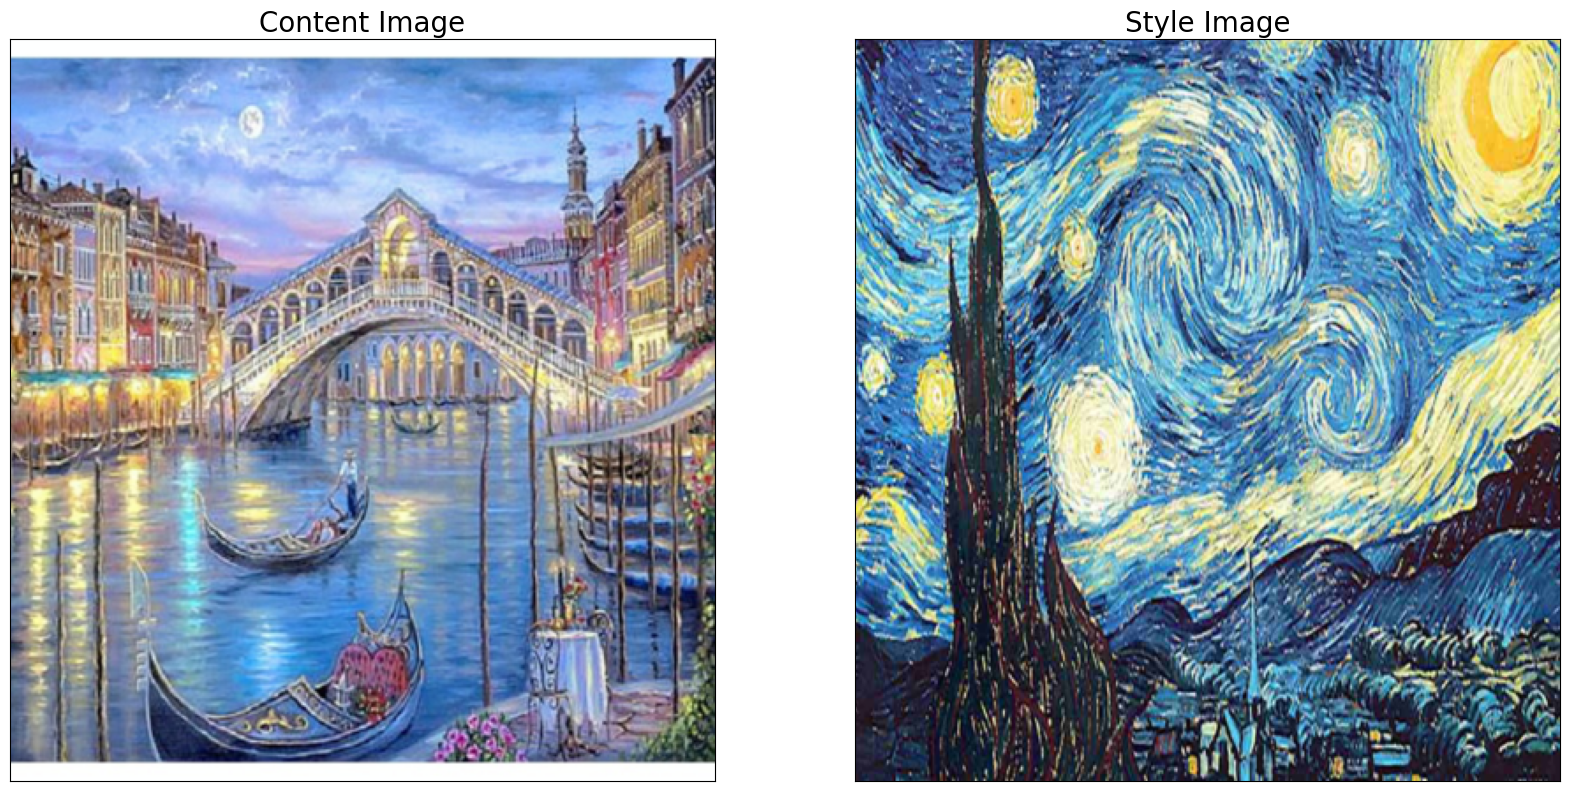

In [ ]:
# 이미지 표시하기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 콘텐츠와 스타일 이미지를 나란히 배치
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=20)

ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=20)

# 눈금 (ticks) 제거
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

# 학습

In [ ]:
# 각 계층의 이름을 볼 수 있도록 VGG19 구조를 인쇄합니다.
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def get_features(image, model, layers=None):
    """
    모델을 통해 이미지를 순방향으로 실행하고
    신경망 계층셋에 대한 특징을 얻습니다.
    기본 신경망 계층은 Gatys et al(2016)과 일치하는 VGGNet용 신경망입니다.
    """
    
    """
    TODO
    * PyTorch의 VGGNet 레이어 이름을 논문의 이름에 매핑 완료하기
    * 이미지의 콘텐츠와 스타일 표현을 위한 레이어가 필요합니다.
    """
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # 콘텐츠 표현
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules는 모델의 각 모듈을 담고 있는 딕셔너리입니다.
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

> 그램 행렬이 뭐야? 11살도 이해할 수 있게, 실생활 비유를 들어, VGG 개념을 바탕으로 설명해줘
* 이미지에서 각각의 픽셀들이 어떤 패턴으로 배열되어 있는지를 나타내는 것입니다. 예를 들어, 이미지 내에서 여러 개의 사물이 있을 경우, 그 사물들 간의 상호작용을 표현하기 위해 사용됩니다.
* https://sharegpt.com/c/PgiFZza

In [ ]:
def gram_matrix(tensor):
    """
    주어진 텐서의 그램 행렬 계산하기 
    그램 행렬: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # 텐서의 batch_size, 깊이, 높이, 너비를 가져옵니다.
    _, d, h, w = tensor.size()
    
    # 차원을 재구성하여 각 채널의 특징을 증강합니다.
    tensor = tensor.view(d, h * w)
    
    # 그램 매트릭스 계산하기
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [ ]:
# 학습 전에 콘텐츠 및 스타일의 특징값을 한 번만 가져오기
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# 스타일 표현의 각 레이어에 대한 그램 매트릭스를 계산합니다.
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 세 번째 "대상" 이미지를 생성하고 변경할 수 있도록 준비합니다.
# 타겟을 *콘텐츠* 이미지의 복사본으로 시작하는 것이 좋습니다.
# 그런 다음 반복적으로 스타일을 변경합니다.
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# 각 스타일 레이어에 대한 가중치 
# 이전 레이어에 가중치를 더 많이 부여하면
# 스타일 아티팩트가 *더 크게* 생성됩니다.
# 콘텐츠 표현에서 'conv4_2'를 제외한다는 점에 유의하세요.
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

여기서 **alpha**와 **beta**는 각각 콘텐츠 손실(content loss)과 스타일 손실(style loss)에 대한 가중치를 의미합니다. 이 가중치를 통해, 전체 손실 함수(loss function)에서 콘텐츠와 스타일의 상대적인 중요도를 조절할 수 있습니다.

**content_weight**는 콘텐츠 손실에 대한 가중치이며, 콘텐츠 이미지와 생성된 이미지 간의 차이를 최소화하는 역할을 합니다. 이 값이 클수록, 콘텐츠 이미지와 생성된 이미지 간의 차이가 더 크게 반영됩니다.

**style_weight**는 스타일 손실에 대한 가중치이며, 스타일 이미지와 생성된 이미지 간의 차이를 최소화하는 역할을 합니다. 이 값이 클수록, 스타일 이미지와 생성된 이미지 간의 차이가 더 크게 반영됩니다.

위 코드에서는 **style_weights** 딕셔너리를 통해, 각 스타일 레이어마다 가중치를 다르게 부여하고 있습니다. 이전 레이어에 가중치를 더 많이 부여하면, 해당 레이어에서 생성되는 스타일 아티팩트가 더 크게 반영됩니다. 또한, **conv4_2** 레이어는 콘텐츠 표현에서 제외하고 있으므로, 해당 레이어에서 생성되는 콘텐츠 아티팩트가 반영되지 않습니다.

In [ ]:
# 대상 이미지를 드물게 표시하기 위해
show_every = 400

# 이터레이션 하이퍼파라미터
optimizer = optim.Adam([target], lr=0.003)
steps = 2000 # 이미지를 업데이트할 반복 횟수 결정(5000회)

for ii in range(1, steps+1):
    
    # 타겟 이미지에서 특징 가져오기
    target_features = get_features(target, vgg)
    
    # 콘텐츠 loss값
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # 스타일 loss값
    # 스타일 loss를 0으로 초기화
    style_loss = 0
    # 입력한 다음 각 레이어의 그램 매트릭스 손실에 대해 추가합니다.
    for layer in style_weights:
        # 레이어의 "대상" 스타일 표현을 가져옵니다.
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # "스타일" 스타일 표현 얻기
        style_gram = style_grams[layer]
        # 한 레이어에 대한 스타일 loss, 적절하게 가중치 부여
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # 스타일 loss에 추가
        style_loss += layer_style_loss / (d * h * w)
        
    # *총* loss 계산
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # 타겟 이미지 업데이트
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # 중간 이미지 표시 및 loss 출력
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
def show_images(content, target):
    # 콘텐츠 및 최종 타겟 이미지 표시
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle("Before VS After", fontsize=16)
    ax1.imshow(im_convert(content))
    ax1.set_title("Content Image", fontsize=12)
    ax2.imshow(im_convert(target))
    ax2.set_title("Stylized Target Image", fontsize=12)
    ax1.grid(False)
    ax2.grid(False)

    # 축 틱 (픽셀 표시) 숨기기
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
show_images(content, target)

In [ ]:
from tqdm.notebook import tqdm
from google.colab import files

def show_images_with_style(content, target, style):
    # 콘텐츠 및 최종 타겟 이미지 표시
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Before VS Style VS After", fontsize=16)
    ax1.imshow(im_convert(content))
    ax1.set_title("Content Image", fontsize=12)
    ax2.imshow(im_convert(style))
    ax2.set_title("Style Image", fontsize=12)
    ax3.imshow(im_convert(target))
    ax3.set_title("Stylized Target Image", fontsize=12)
    ax1.grid(False)
    ax2.grid(False)

    # 축 틱 (픽셀 표시) 숨기기
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax3.set_yticks([])

    plt.tight_layout()
    plt.show()

def apply_styles(content_fname, style_fname, steps=5000):
    # 콘텐츠 및 스타일 이미지 불러오기
    # content_fname = 'sight.jpg' #@param{"type":"string"}
    content = load_image(content_fname).to(device)
    # 콘텐츠에 맞게 스타일 크기 조정, 코드 작성 용이성 향상
    # style_fname = 'starrynight.jpg' #@param{"type":"string"}
    style = load_image(style_fname, shape=content.shape[-2:]).to(device)

    # 학습 전에 콘텐츠 및 스타일의 특징값을 한 번만 가져오기
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    # 스타일 표현의 각 레이어에 대한 그램 매트릭스를 계산합니다.
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # 세 번째 "대상" 이미지를 생성하고 변경할 수 있도록 준비합니다.
    # 타겟을 *콘텐츠* 이미지의 복사본으로 시작하는 것이 좋습니다.
    # 그런 다음 반복적으로 스타일을 변경합니다.
    target = content.clone().requires_grad_(True).to(device)

    # 대상 이미지를 드물게 표시하기 위해
    show_every = 400

    # 이터레이션 하이퍼파라미터
    optimizer = optim.Adam([target], lr=0.003)
    # steps = 2000 # 이미지를 업데이트할 반복 횟수 결정(5000회)

    for ii in tqdm(range(1, steps+1)):
        
        # 타겟 이미지에서 특징 가져오기
        target_features = get_features(target, vgg)
        
        # 콘텐츠 loss값
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
        
        # 스타일 loss값
        # 스타일 loss를 0으로 초기화
        style_loss = 0

        # 입력한 다음 각 레이어의 그램 매트릭스 손실에 대해 추가합니다.
        for layer in style_weights:
            # 레이어의 "대상" 스타일 표현을 가져옵니다.
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            # "스타일" 스타일 표현 얻기
            style_gram = style_grams[layer]
            # 한 레이어에 대한 스타일 loss, 적절하게 가중치 부여
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            # 스타일 loss에 추가
            style_loss += layer_style_loss / (d * h * w)
            
        # *총* loss 계산
        total_loss = content_weight * content_loss + style_weight * style_loss
        
        # 타겟 이미지 업데이트
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return content, target, style

Saving 다운로드 (2).jpg to 다운로드 (2).jpg


Saving 222.jpg to 222.jpg


  0%|          | 0/20000 [00:00<?, ?it/s]

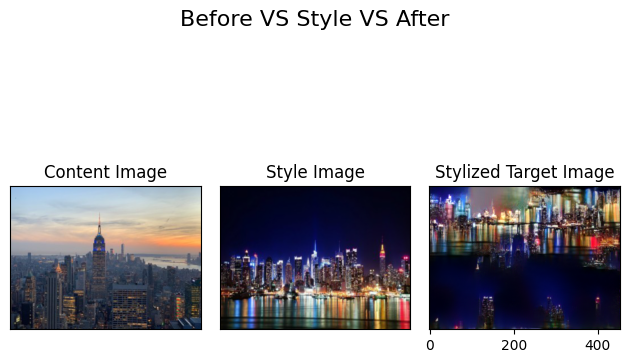

In [ ]:
c_fname = list(files.upload().keys())[0]
s_fname = list(files.upload().keys())[0]
show_images_with_style(*apply_styles(c_fname, s_fname, 20000))